In [3]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
import pandas as pd
import scipy.io as io

import matplotlib.pyplot as plt
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split

import seaborn as sns

%load_ext autoreload
%autoreload 2


In [4]:
OVERWRITE = False
np.random.seed(42)

In [5]:
experiment_name = 'data'
data_dir = f'./data/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])
eyefiles = sorted(list(exp.data_dir.glob('*eyetracking*.mat')))

In [6]:
exp.nsub

16

In [4]:
time_window = 25 
time_step = 25
trial_bin_size = 16
n_splits = 1000
# group_dict = OrderedDict([('SS1_col_c0',[100]),('SS1_col_c1',[101]), ('SS1_mot_c0',[110]), ('SS1_mot_c1',[111]), ('SS2_col_c0',[200]),('SS2_col_c1',[201]),('SS2_col_c2',[202]), ('SS2_mot_c0',[210]), ('SS2_mot_c1',[211]),('SS2_mot_c2',[212])])
# training_labels = ['SS1_mot_c0', 'SS1_mot_c1']  # train to decode coherence during attend-motion trials
# wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=training_labels)
# clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [5]:
def str_to_arr(s, sep=' '):
    pieces = s.replace('[', '').replace(']', '').replace(',', '').split(sep)
    return np.array([float(i) for i in pieces])

def get_target_coherences(row):
    return int(np.sum(str_to_arr(row['Coherences'])[:row['SetSize']]))

def get_distractor_coherences(row):
    return int(np.sum(str_to_arr(row['Coherences'])[row['SetSize']:]))

def add_condition_info(beh):
    beh['cond_labels'] = beh['BlockFeature']*100+100  # color = 100, motion = 200
    beh['cond_labels'] += beh['SetSize']*10  # ss1=10, ss2=20
    beh['cond_labels'] += beh.apply(get_target_coherences, axis=1)*1  # coherence = 0, 1, 2

    # add info about the distractor coherence, shown below to be uninformative generally
    beh['full_cond_labels'] =  beh['cond_labels'].values*10 # shift by 1 decimal place
    beh['full_cond_labels'] += beh.apply(get_distractor_coherences, axis=1)  # distractor coherence = 0, 1, 2

    return beh

In [6]:
def train_model_on_pairs(condition_pairs, subtitle, n_splits=n_splits, default_bad_eyes=[14], cond_column='full_cond_labels'):
    if OVERWRITE:
        group_dict = OrderedDict([('incoherent distractors',[c[0] for c in condition_pairs]),('coherent distractors',[c[1] for c in condition_pairs])])
        wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
        clfr = eeg_decoder.Classification(wrangl,exp.nsub)
        clfr_eyes = eeg_decoder.Classification(wrangl,exp.nsub)

        bad_eye_subs = []
        for isub in range(exp.nsub):
            print(isub)

            # get the "original" xdata (og), which will be copied and modified for each permutation
            xdata_eeg,_ = exp.load_eeg(isub)
            eyedata = io.loadmat(eyefiles[isub])['eyetracking']
            eyedata = np.rollaxis(eyedata, -1)  # reorder to trial, feat, time
            try:
                xdata_og = np.concatenate([xdata_eeg,eyedata],axis=1)  # combine eyedata so it goes along for the ride
            except:
                bad_eye_subs.append(isub)
                xdata_og = xdata_eeg

            # get the original ydata labels for each trial, which will be copied and modified for each permutation
            beh = pd.DataFrame(exp.load_behavior(isub))
            beh = add_condition_info(beh)
            ydata_og = beh[cond_column].values

            for i in range(n_splits):
                clfr.wrangl.ifold = i
                clfr_eyes.wrangl.ifold = i
                
                # permute the og data
                randomization_idx = np.random.permutation(len(ydata_og))
                ydata= ydata_og[randomization_idx]
                xdata = xdata_og[randomization_idx]

                # get the indices of the relevant conditions, and make sure there are the same number of trials for each condition within a pair
                full_indices = np.array([])
                for cond_pair in condition_pairs:
                    a_idx = np.where(ydata == cond_pair[0])[0]
                    b_idx = np.where(ydata == cond_pair[1])[0]
                    if i==0:
                        print(f'{cond_pair[0]}: {len(a_idx)} trials | {cond_pair[1]}: {len(b_idx)} trials')
                        # print(f'condition pair {cond_pair}: {min_count} trials')
                    min_count = min(len(a_idx), len(b_idx))
                    a_idx = a_idx[:min_count]
                    b_idx = b_idx[:min_count]
                    

                    full_indices = np.concatenate([full_indices, a_idx, b_idx])
                full_indices = full_indices.astype(int)
                ydata = ydata[full_indices]
                xdata = xdata[full_indices]

                # relabel conditions to 1s and 0s. Bin, and balance
                xdata,ydata = wrangl.group_labels(xdata,ydata)
                xdata_binned,ydata_binned = wrangl.bin_trials(xdata,ydata)
                X_train_all, X_test_all, y_train, y_test = train_test_split(
                                    xdata_binned, ydata_binned, stratify=ydata_binned, test_size=.2
                                )
                X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test, minimize_loss=True)

                y_test_shuffle = np.random.permutation(y_test)  # get shuffled version to compare accuracy against

                # train the models!
                for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

                    # separate EEG and eye data for models
                    X_train_eeg = X_train[:, :30]
                    X_test_eeg = X_test[:, :30]
                    clfr.decode(X_train_eeg,X_test_eeg,y_train,y_test,y_test_shuffle,isub)
                    if X_train.shape[1] > 30:  # if they have eye data
                        X_train_eye = X_train[:, 30:]
                        X_test_eye = X_test[:, 30:]
                        clfr_eyes.decode(X_train_eye,X_test_eye,y_train,y_test,y_test_shuffle,isub)

        interp = eeg_decoder.Interpreter(clfr, subtitle=subtitle) 
        interp.save_results(timestamp=False)

        interp_eyes = eeg_decoder.Interpreter(clfr_eyes, subtitle=subtitle+'_eyes')
        interp_eyes.save_results(timestamp=False)
        print(bad_eye_subs)
    else:
        bad_eye_subs = default_bad_eyes
    return bad_eye_subs

In [7]:
def train_model(condition_names, condition_codes, subtitle, default_bad_eyes=[14], cond_column='cond_labels'):
    group_dict = OrderedDict([(n, c) for n, c in zip(condition_names, condition_codes)])
    wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
    clfr = eeg_decoder.Classification(wrangl,exp.nsub)
    clfr_eyes = eeg_decoder.Classification(wrangl,exp.nsub)

    if OVERWRITE:
        bad_eye_subs = []
        for isub in range(exp.nsub):
            print(isub)

            xdata_eeg,_ = exp.load_eeg(isub)
            eyedata = io.loadmat(eyefiles[isub])['eyetracking']
            eyedata = np.rollaxis(eyedata, -1)  # reorder to trial, feat, time
            try:
                xdata = np.concatenate([xdata_eeg,eyedata],axis=1)  # combine eyedata so it goes along for the ride
            except:
                bad_eye_subs.append(isub)
                xdata = xdata_eeg

            beh = pd.DataFrame(exp.load_behavior(isub))
            beh = add_condition_info(beh)
            ydata = beh[cond_column].values


            indices = [y in condition_codes for y in ydata]
            ydata = ydata[indices]
            xdata = xdata[indices]

            xdata,ydata = wrangl.group_labels(xdata,ydata)  # relabel to match names, set to 0 and 1

            for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

                X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)

                y_test_shuffle = np.random.permutation(y_test)

                for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    # separate EEG and eye data
                    X_train_eeg = X_train[:, :30]
                    X_test_eeg = X_test[:, :30]
                    clfr.decode(X_train_eeg,X_test_eeg,y_train,y_test,y_test_shuffle,isub)
                    if X_train.shape[1] > 30:  # if they have eye data
                        X_train_eye = X_train[:, 30:]
                        X_test_eye = X_test[:, 30:]
                        clfr_eyes.decode(X_train_eye,X_test_eye,y_train,y_test,y_test_shuffle,isub)


        interp = eeg_decoder.Interpreter(clfr, subtitle=subtitle) 
        interp.save_results(timestamp=False)

        interp_eyes = eeg_decoder.Interpreter(clfr_eyes, subtitle=subtitle+'_eyes')
        interp_eyes.save_results(timestamp=False)
        print(bad_eye_subs)
    else:
        bad_eye_subs = default_bad_eyes
    return bad_eye_subs

In [8]:
def interpret_results(subtitle, bad_eye_subs=None, ylim=[-1, 2], stim_time=[0, 500],label='Coherence Level', savefig=True):
    interp = eeg_decoder.Interpreter()
    interp.load_results(subtitle)
    if bad_eye_subs is not None:
        interp.confidence_scores = np.delete(interp.confidence_scores, bad_eye_subs, axis=0)
        interp.confidence_scores_shuff = np.delete(interp.confidence_scores_shuff, bad_eye_subs, axis=0)

    interp.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    interp.plot_hyperplane(
        stim_time=stim_time,
        ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
        savefig=False,subtitle='Blank',legend_pos='lower left')
    
    hyp_diff = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]  # SS2_col - SS1_col
    hyp_scores = np.mean(hyp_diff, axis=2)

    hyp_diff_shuff = interp.confidence_scores_shuff[..., 1] - interp.confidence_scores_shuff[..., 0]
    hyp_scores_shuff = np.mean(hyp_diff_shuff, axis=2)

    # ylim = [-1, 2]
    stim_lower = ylim[0] + 0.01
    stim_upper = ylim[1]

    ax = plt.subplot(111)


    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")
    # ax.axhline(y=0, color="grey", linestyle="--")


    # plot the shuffled labels results
    mean, upper, lower = interp.get_plot_line(hyp_scores_shuff)
    ax.plot(interp.t, mean, 'gray', label='Shuffle')
    ax.fill_between(interp.t, upper, lower, color='gray', alpha=0.5)

    # plot the actual results
    mean, upper, lower = interp.get_plot_line(hyp_scores)
    ax.plot(interp.t, mean, 'tab:cyan', label=label)
    ax.fill_between(interp.t, upper, lower, color='tab:cyan', alpha=0.5)

    _, ps = sista.ttest_rel(hyp_scores, hyp_scores_shuff, axis=0, alternative="greater")
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    plt.scatter(
        interp.t[sig05],
        np.ones(sum(sig05))*-.4,
        marker="s",
        s=33,
        c='tab:cyan'
    )

    plt.title(f'Hyperplane contrast: {subtitle}')
    _ = plt.legend()
    sns.despine()
    if savefig:
        plt.savefig(f'output/figures/hyperplane_contrast_{subtitle}.svg')
    plt.show()
    plt.close()
        
    return hyp_diff

In [9]:
def correlate_contrasts(interp, cond_diff_eyes, cond_diff_eeg, subtitle, stim_time=[0, 500], ylim = [-.1, .1], ylim_stds = [0, 2]):

    nsubs = cond_diff_eyes.shape[0]
    ntimes = cond_diff_eyes.shape[1]
    cond_corrs = np.zeros((nsubs,ntimes))

    for isub in range(nsubs):
        for t in range(ntimes):
            # correlations are immediately Fisher transformed
            cond_corrs[isub, t] = np.arctanh(np.corrcoef(cond_diff_eyes[isub, t], cond_diff_eeg[isub, t])[0, 1])

    # plot correlations
    stim_lower = ylim[0] + 0.01
    stim_upper = ylim[1]

    ax = plt.subplot(111)

    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")

    i = 0
    mean, upper, lower = interp.get_plot_line(cond_corrs)
    ax.plot(interp.t, mean, 'tab:cyan')
    ax.fill_between(interp.t, upper, lower, color='tab:cyan', alpha=0.5)

    _, ps = sista.ttest_1samp(cond_corrs, popmean=0, axis=0, alternative="greater")
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    if sum(sig05):
        plt.scatter(
            interp.t[sig05],
            np.ones(sum(sig05))*-.05,
            marker="s",
            s=33,
            c='tab:cyan'
        )
    else:
        print(f'no significant correlations for condition {subtitle}')

    plt.title("Fisher's z of permutation contrasts between EEG and eye models")
    sns.despine()
    plt.savefig(f'output/figures/corrs_{subtitle}.svg')
    plt.show()
    plt.close()

    # look at standard deviations across permutations
    cond_std_eyes = np.zeros((nsubs,ntimes))
    cond_stds_eeg = np.zeros((nsubs,ntimes))

    for isub in range(nsubs):
        for t in range(ntimes):
            cond_std_eyes[isub, t] = np.std(cond_diff_eyes[isub, t])
            cond_stds_eeg[isub, t] = np.std(cond_diff_eeg[isub, t])


    # convert to data frames
    cond_std_eyes=pd.DataFrame(cond_std_eyes).T
    cond_std_eyes['time'] = interp.t
    cond_std_eyes = cond_std_eyes.melt(id_vars='time',var_name='subject',value_name="std")
    cond_std_eyes['Data Type'] = 'Eye'

    cond_stds_eeg=pd.DataFrame(cond_stds_eeg).T
    cond_stds_eeg['time'] = interp.t
    cond_stds_eeg = cond_stds_eeg.melt(id_vars='time',var_name='subject',value_name="std")
    cond_stds_eeg['Data Type'] = 'EEG'

    stds = pd.concat([cond_std_eyes,cond_stds_eeg])
    
    stim_lower = ylim_stds[0] + 0.01
    stim_upper = ylim_stds[1]

    ax = plt.subplot(111)
    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    sns.lineplot(data=stds,x='time',y="std", style='Data Type', color='tab:cyan')
    _ = plt.ylim(ylim_stds)

    plt.title("Standard deviation of contrasts across permutations")
    _ = plt.legend()
    sns.despine()
    plt.savefig(f'output/figures/stds_{subtitle}.svg')
    plt.show()
    plt.close()
    

# Can we decode the number of unattended coherent dot clouds?
## using all possible pairs of conditions that only differ in the number of coherent distractors

## 1.1 - Attend Motion

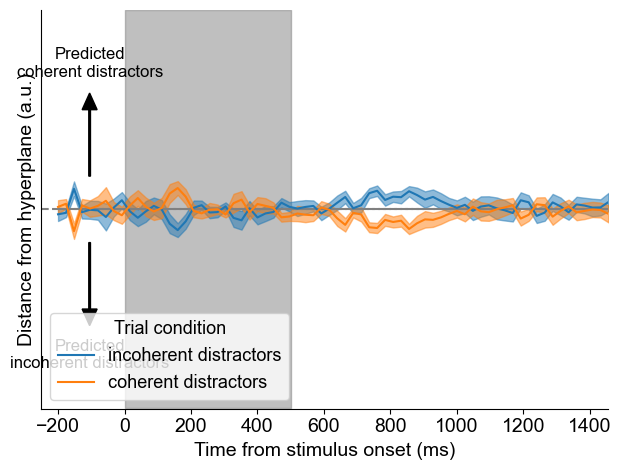

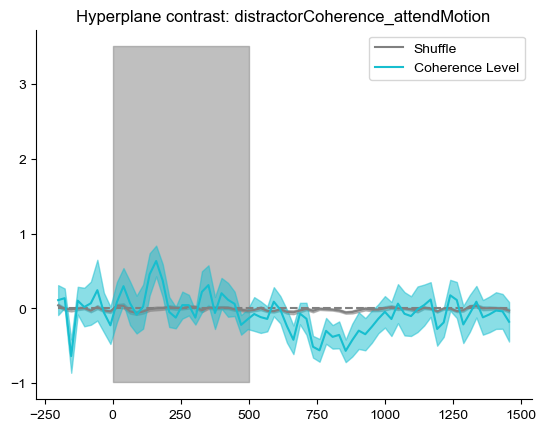

In [10]:
# 1: SS1, no coherent targets, 1 vs 2 coherent distractors
# 2: SS1, 1 coherent target, 0 vs 1 coherent distractors
# 3: SS2: 1 coherent target, 0 vs 1 coherent distractors
condition_pairs = [(2101, 2102), (2110, 2111), (2210, 2211)]
subtitle = 'distractorCoherence_attendMotion'

bad_eye_subs = train_model_on_pairs(condition_pairs, subtitle, n_splits)

_ = interpret_results('distractorCoherence_attendMotion', ylim=[-1, 3.5])

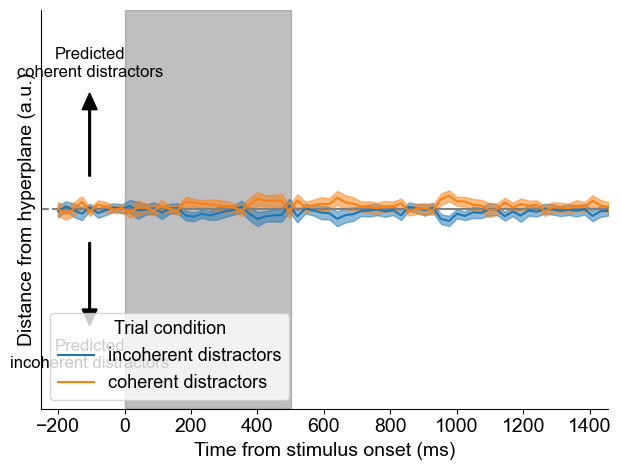

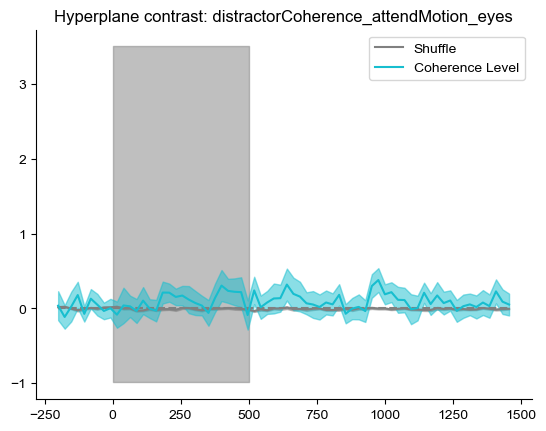

In [11]:
diff_eyes = interpret_results('distractorCoherence_attendMotion_eyes', ylim=[-1, 3.5], bad_eye_subs=bad_eye_subs)

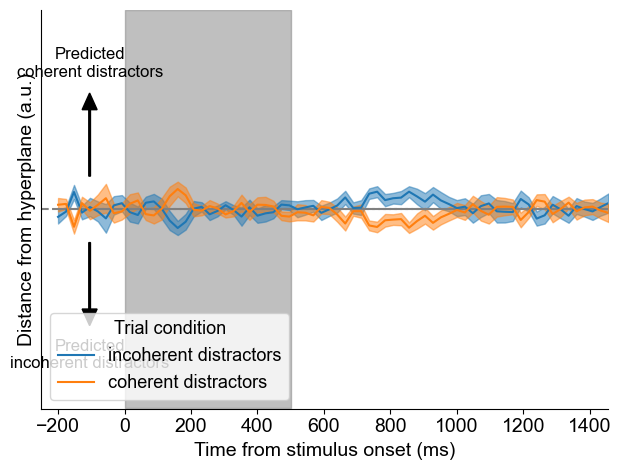

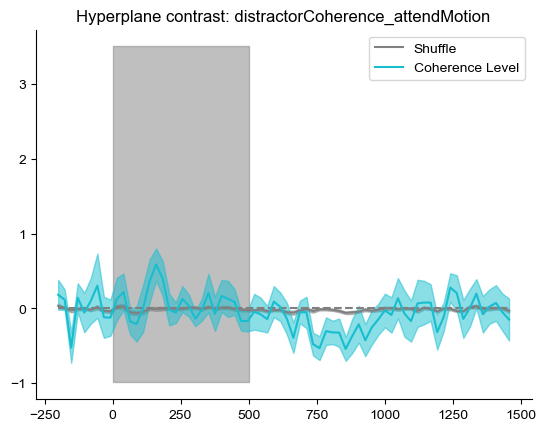

In [12]:
diff_eeg = interpret_results('distractorCoherence_attendMotion', ylim=[-1, 3.5], bad_eye_subs=bad_eye_subs, savefig=False)

no significant correlations for condition distractorCoherence_attendMotion


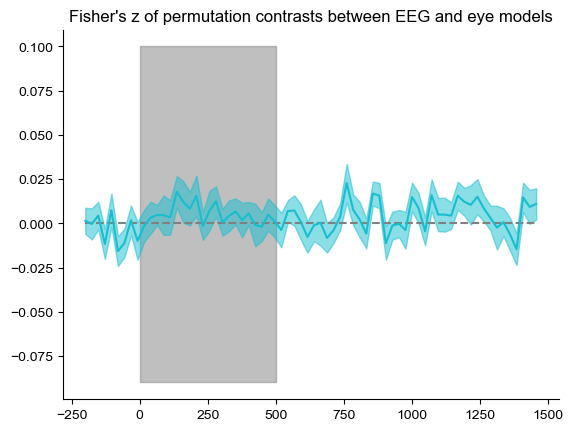

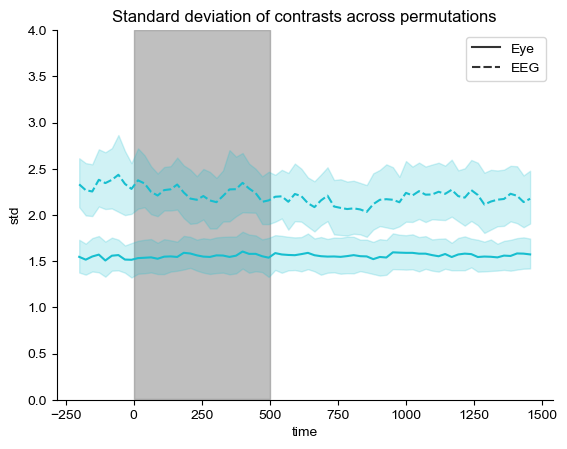

In [13]:
interp = eeg_decoder.Interpreter()
interp.load_results('distractorCoherence_attendMotion')
correlate_contrasts(interp, diff_eyes, diff_eeg, subtitle='distractorCoherence_attendMotion', ylim_stds=[0, 4])

## 1.2 - Attend Color

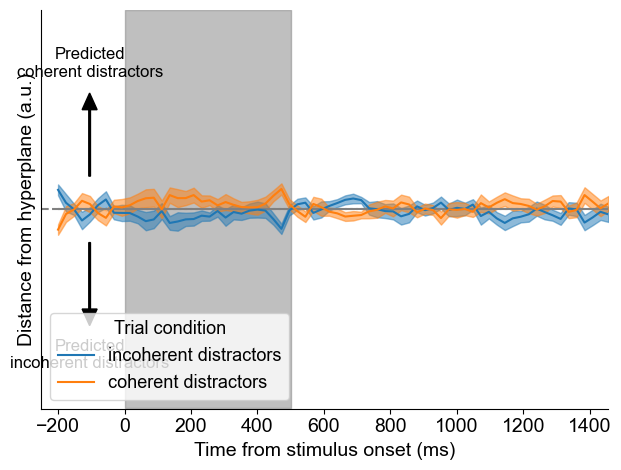

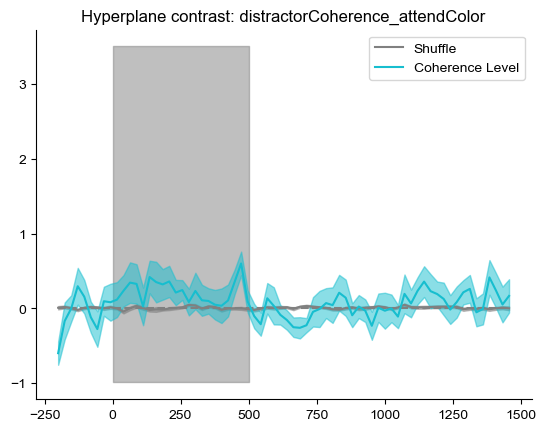

In [14]:
condition_pairs = [(1101, 1102), (1110, 1111), (1210, 1211)]
subtitle = 'distractorCoherence_attendColor'

train_model_on_pairs(condition_pairs, subtitle, n_splits)
_ = interpret_results('distractorCoherence_attendColor', ylim=[-1, 3.5])

# Can run subset pairs here as well

In [15]:
RUN_SUBSETS = False

In [16]:
if RUN_SUBSETS:
    # one example
    bad_eye_subs = train_model(['SS2_Motion_1Targ_0Dist', 'SS2_Motion_1Targ_1Dist'], [1210, 1211], 'distractorCoherence_SS2_attendMotion')
    _ = interpret_results('distractorCoherence_SS2_attendMotion', ylim=[-1, 3.5])

# Second Analysis - Can we decode the amount of coherent clouds attended while controlling the total number?

## SS1 0 coherent target vs SS1 1 coherent target

## 2.1 - Attend Motion

In [17]:
bad_eye_subs = train_model(['Motion_SS1_0Coh', 'Motion_SS1_1Coh'], [210, 211], 'attendedCoherence_SS1_attendMotion')

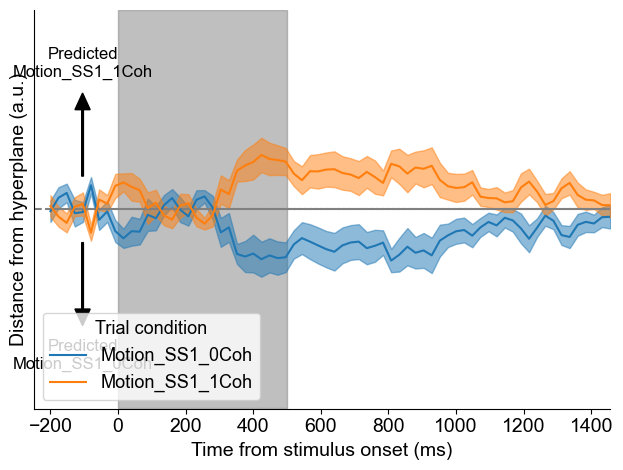

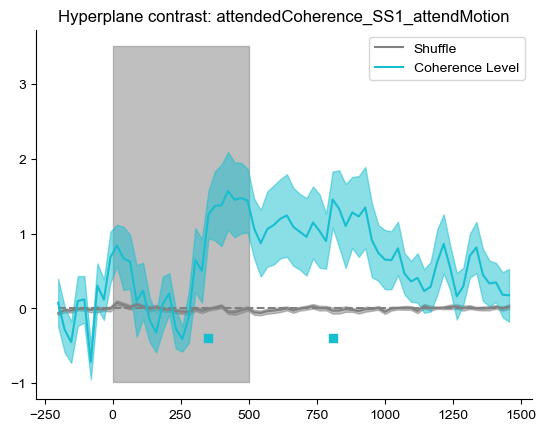

In [18]:
_ = interpret_results('attendedCoherence_SS1_attendMotion', ylim=[-1, 3.5])

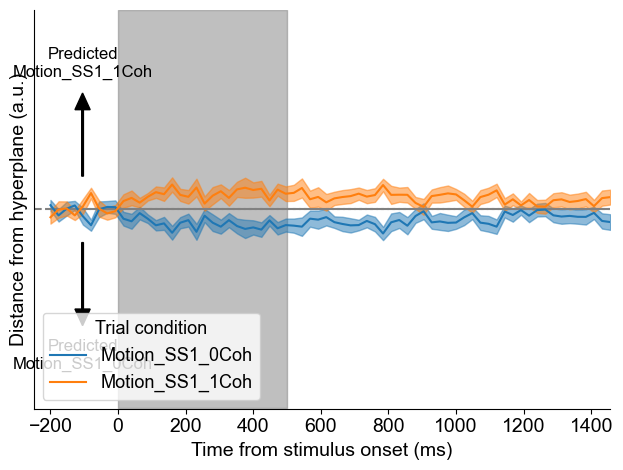

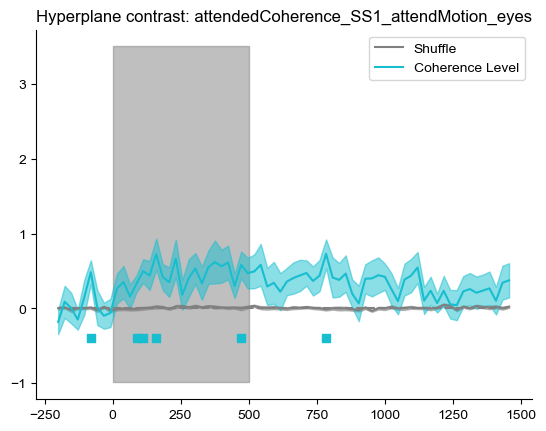

In [19]:
diff_eyes = interpret_results('attendedCoherence_SS1_attendMotion_eyes', ylim=[-1, 3.5], bad_eye_subs=bad_eye_subs)

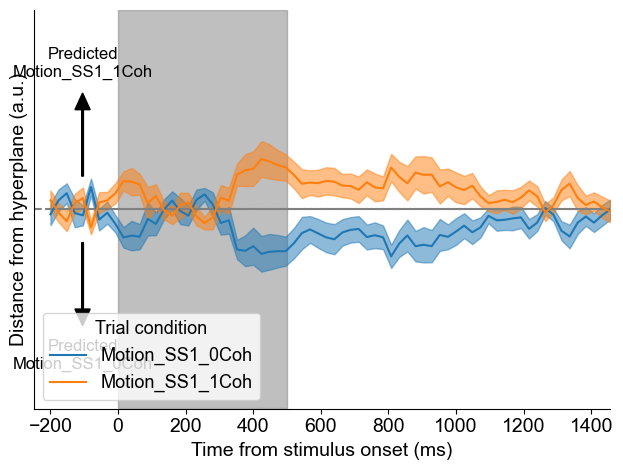

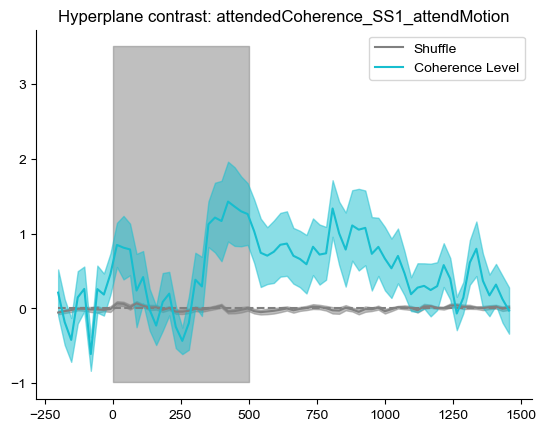

In [20]:
diff_eeg = interpret_results('attendedCoherence_SS1_attendMotion', ylim=[-1, 3.5], bad_eye_subs=bad_eye_subs, savefig=False)

no significant correlations for condition attendedCoherence_SS1_attendMotion


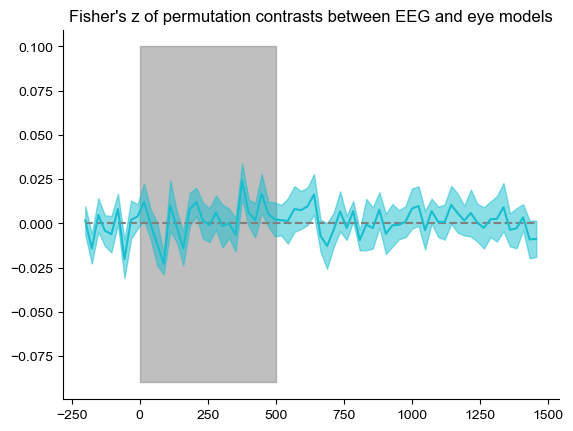

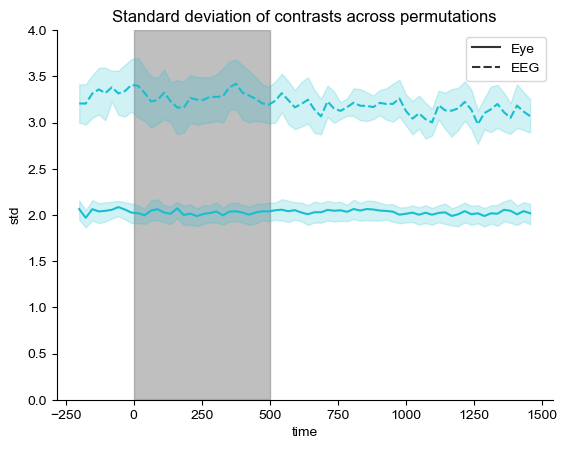

In [21]:
interp = eeg_decoder.Interpreter()
interp.load_results('attendedCoherence_SS1_attendMotion')
correlate_contrasts(interp, diff_eyes, diff_eeg, subtitle='attendedCoherence_SS1_attendMotion', ylim_stds=[0, 4])

## 2.2 - Attend Color

In [22]:
bad_eye_subs = train_model(['Color_SS1_0Coh', 'Color_SS1_1Coh'], [110, 111], 'attendedCoherence_SS1_attendColor')

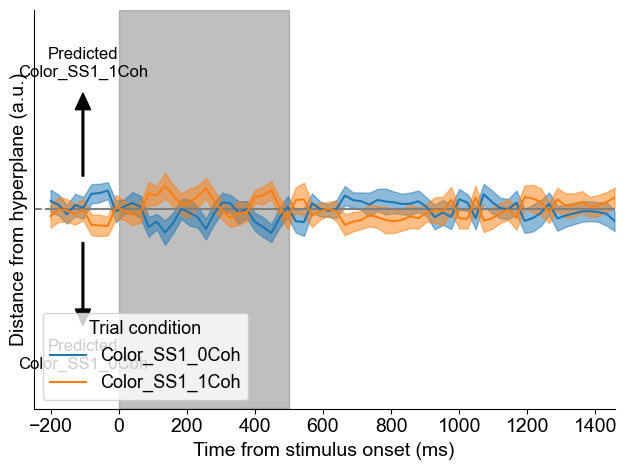

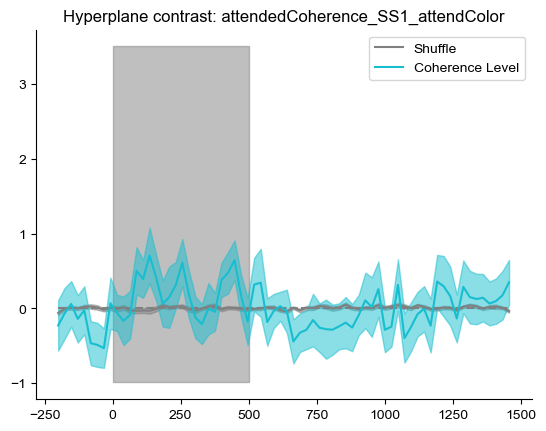

In [23]:
_ = interpret_results('attendedCoherence_SS1_attendColor', ylim=[-1, 3.5])

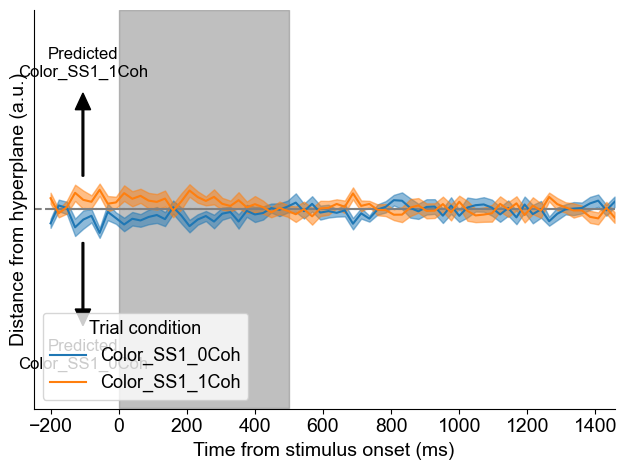

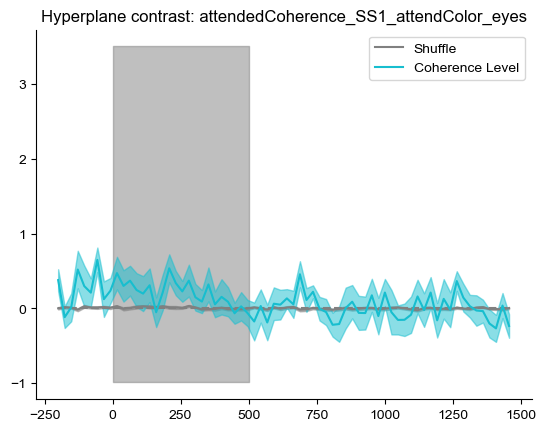

In [24]:
_ = interpret_results('attendedCoherence_SS1_attendColor_eyes', ylim=[-1, 3.5], bad_eye_subs=bad_eye_subs)

# For RSA: train on SS1 attend motion coherence, look at all conditions

In [25]:
n_splits=50

In [26]:
# order of conditions will match the RSA conditions
group_dict = OrderedDict([
    ('col_ss1_coh0',[110]),
    ('col_ss1_coh1',[111]),
    ('col_ss2_coh0',[120]),
    ('col_ss2_coh1',[121]),
    ('col_ss2_coh2',[122]),
    ('mot_ss1_coh0',[210]),
    ('mot_ss1_coh1',[211]),
    ('mot_ss2_coh0',[220]),
    ('mot_ss2_coh1',[221]),
    ('mot_ss2_coh2',[222]),
    ])
training_labels = ['mot_ss1_coh0', 'mot_ss1_coh1']  # train to decode coherence during attend-motion trials
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=training_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)


In [27]:
if OVERWRITE:
    for isub in range(exp.nsub):
        print(isub)

        xdata,_ = exp.load_eeg(isub)
        beh = pd.DataFrame(exp.load_behavior(isub))
        beh = add_condition_info(beh)
        ydata = beh['cond_labels'].values

        xdata,ydata = wrangl.group_labels(xdata,ydata)

        for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata, train_labels=training_labels):

            X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)

            y_test_shuffle = np.random.permutation(y_test)

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

    interp = eeg_decoder.Interpreter(clfr, subtitle='coherence_axis')
    interp.save_results(timestamp=False)

In [28]:
interp_coh = eeg_decoder.Interpreter()
interp_coh.load_results('coherence_axis')
# reset colors
interp_coh.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

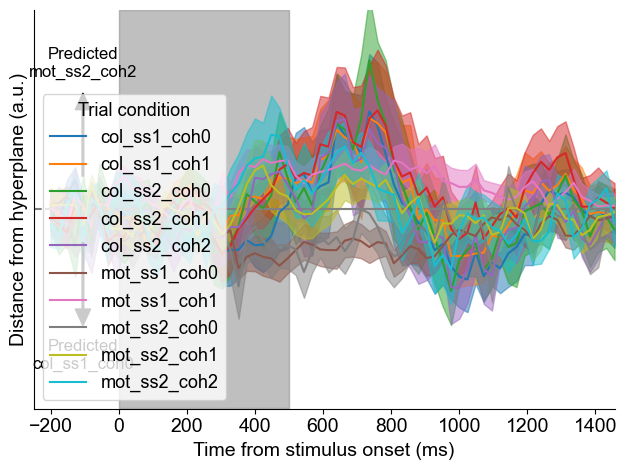

In [29]:
interp_coh.plot_hyperplane(
    stim_time=[0,500],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
    savefig=False,subtitle='Blank',legend_pos='lower left')